In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from IPython import display
from tensorflow.data import Dataset

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Embedding, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D, Concatenate

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model

In [2]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

In [3]:
# set gpu memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# set random seed
tf.random.set_seed(42)
np.random.seed(42)

## Load Dataset

In [5]:
FILE_PATH = 'data\cifar10.tfrecords'
dataset = Dataset.load(FILE_PATH)
print(dataset.element_spec)

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))


## Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)

### Defining Generator

In [6]:
def create_generator(latent_dim):
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    
    # linear activation
    label_embedding = Dense(4 * 4 , name='label_dense')(label_embedding)

    # reshape to additional channel
    label_embedding = Reshape((4, 4, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 4, 4, 1)

    # foundation for 4x4 image input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    noise_dense = Dense(4 * 4 * 128, activation='relu', name='noise_dense')(noise_input)
    noise_reshape = Reshape((4, 4, 128), name='noise_reshape')(noise_dense)
    assert noise_reshape.shape == (None, 4, 4, 128)

    # concatenate label embedding and image to produce 129-channel output
    concat = keras.layers.Concatenate(name='concatenate')([noise_reshape, label_embedding])
    assert concat.shape == (None, 4, 4, 129)

    # upsample to 8x8
    conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu', name='conv1')(concat)
    assert conv1.shape == (None, 8, 8, 128)
    conv1 = BatchNormalization(name='conv1_batchnorm')(conv1)

    # upsample to 16x16
    conv2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu', name='conv2')(conv1)
    assert conv2.shape == (None, 16, 16, 128)
    conv2 = BatchNormalization(name='conv2_batchnorm')(conv2)

    # upsample to 32x32
    conv3 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu', name='conv3')(conv2)
    assert conv3.shape == (None, 32, 32, 128)
    conv3 = BatchNormalization(name='conv3_batchnorm')(conv3)

    # output 32x32x3
    output = Conv2D(3, (3, 3), activation='tanh', padding='same', name='output')(conv3)
    assert output.shape == (None, 32, 32, 3)

    model = Model(inputs=[noise_input, label_input], outputs=output, name='generator')

    return model

In [7]:
generator = create_generator(latent_dim=128)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 noise_dense (Dense)            (None, 2048)         264192      ['noise_input[0][0]']            
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                          

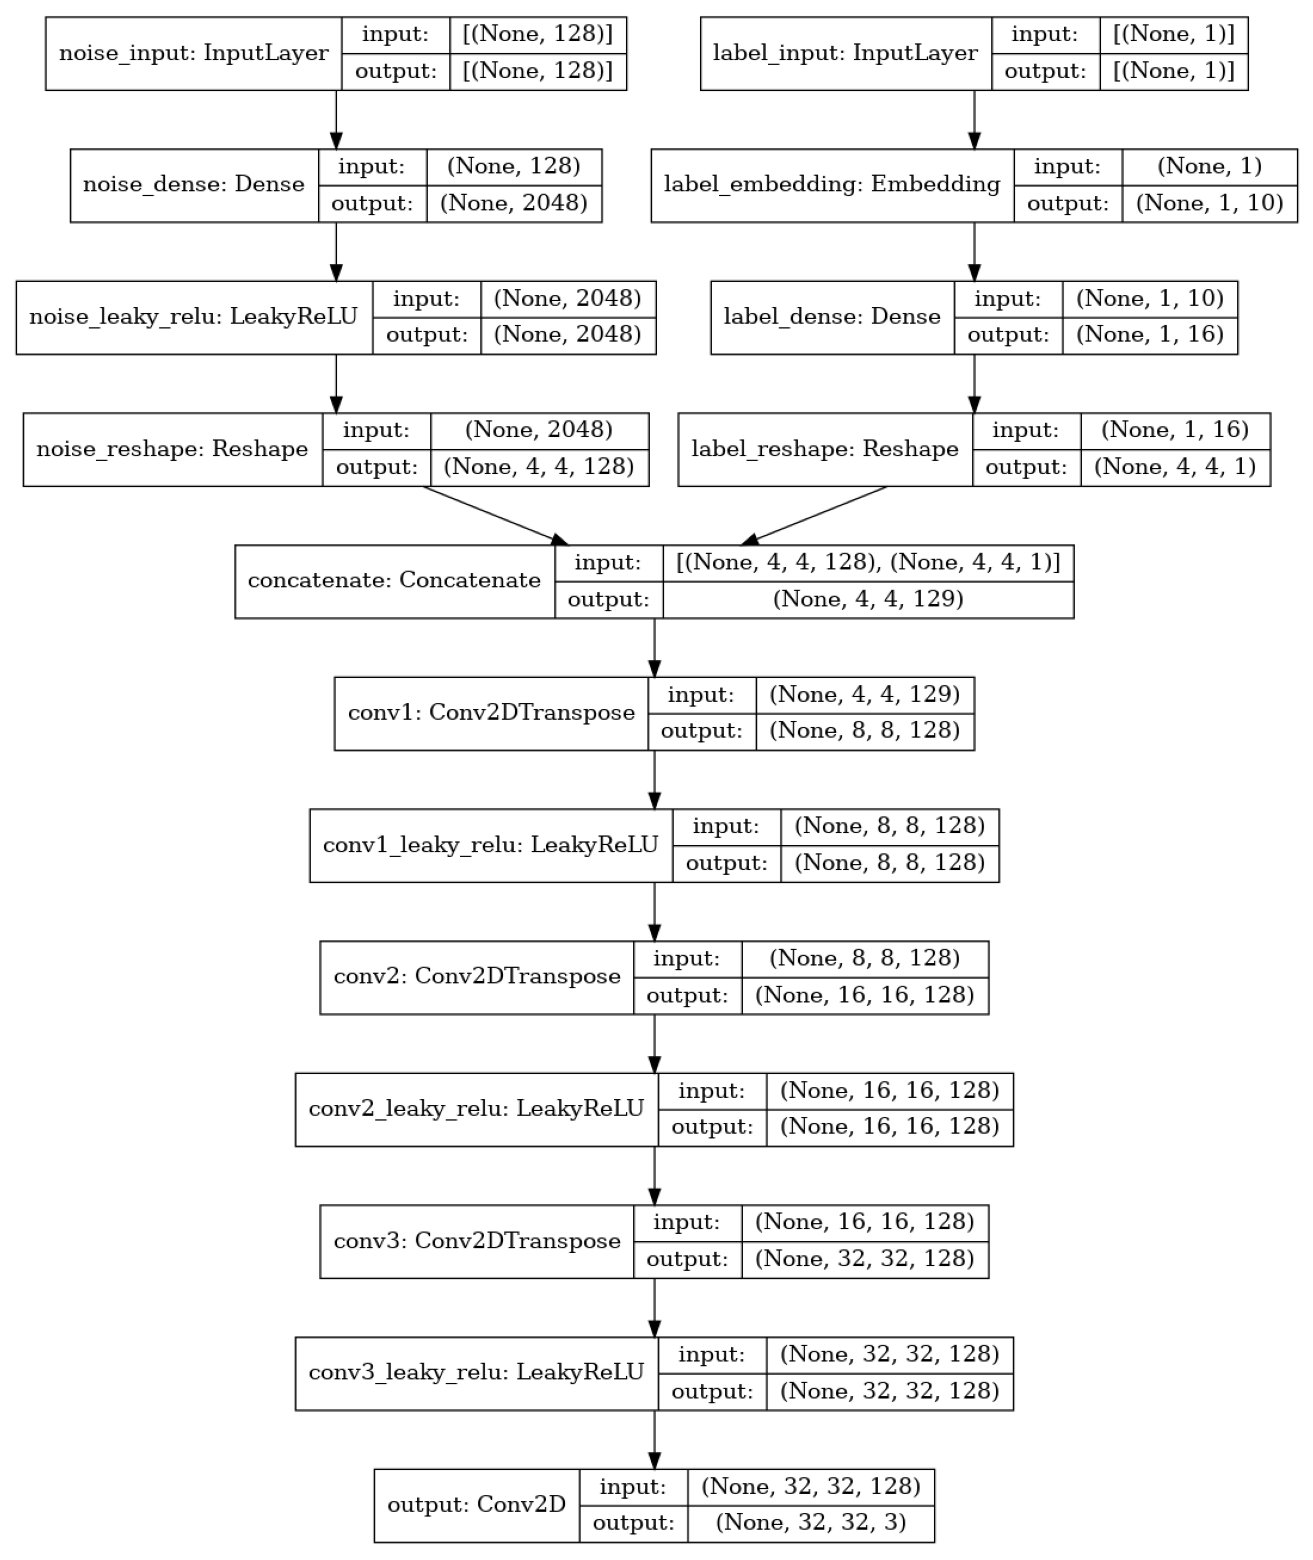

In [3]:
# visualize generator
# plot_model(generator, show_shapes=True, to_file='images\model_architecture\Conditional_DCGAN\generator.png')
# generator_img = mpimg.imread('images\model_architecture\Conditional_DCGAN\generator.png')

# plt.figure(figsize=(20, 20))
# imgplot = plt.imshow(generator_img)
# plt.axis('off')
# plt.show()

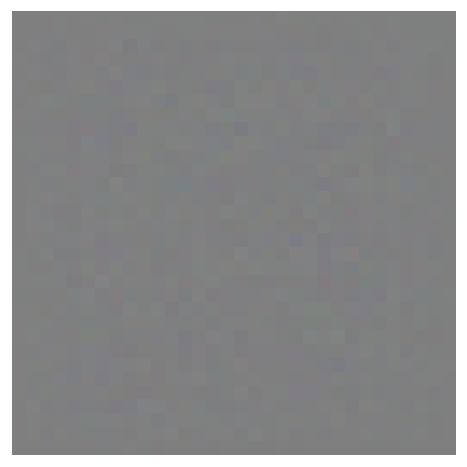

In [11]:
# test untrained generator
noise = tf.random.normal([1, 128])
label = tf.random.uniform([1], minval=0, maxval=10, dtype=tf.int32)
generated_image = generator([noise, label], training=False)
plt.imshow((generated_image[0] + 1) / 2)
plt.axis('off')
plt.show()

### Defining Discriminator

In [12]:
def create_discriminator():
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    # linear activation
    label_embedding = Dense(32 * 32, name='label_dense')(label_embedding)
    # reshape to additional channel
    label_embedding = Reshape((32, 32, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 32, 32, 1)

    # foundation for 32x32 image input
    image_input = Input(shape=(32, 32, 3), name='image_input')

    # concatenate label embedding and image to produce 129-channel input
    concat = keras.layers.Concatenate(name='concatenate')([image_input, label_embedding])
    assert concat.shape == (None, 32, 32, 4)

    # downsample to 16x16
    conv1 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 16, 16, 128)
    conv1 = LeakyReLU(alpha=0.2, name='conv1_leaky_relu')(conv1)

    # downsample to 8x8
    conv2 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 8, 8, 128)
    conv2 = BatchNormalization(name='conv2_batchnorm')(conv2)
    conv2 = LeakyReLU(alpha=0.2, name='conv2_leaky_relu')(conv2)

    # downsample to 4x4
    conv3 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 4, 4, 128)
    conv3 = BatchNormalization(name='conv3_batchnorm')(conv3)
    conv3 = LeakyReLU(alpha=0.2, name='conv3_leaky_relu')(conv3)

    # flatten feature maps
    flat = Flatten(name='flatten')(conv3)
    
    output = Dense(units=1, activation='sigmoid', name='output')(flat)

    model = Model(inputs=[image_input, label_input], outputs=output, name='discriminator')

    return model

In [13]:
discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                                  
 label_dense (Dense)            (None, 1, 1024)      11264       ['label_embedding[0][0]']        
                                                                                                  
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                      

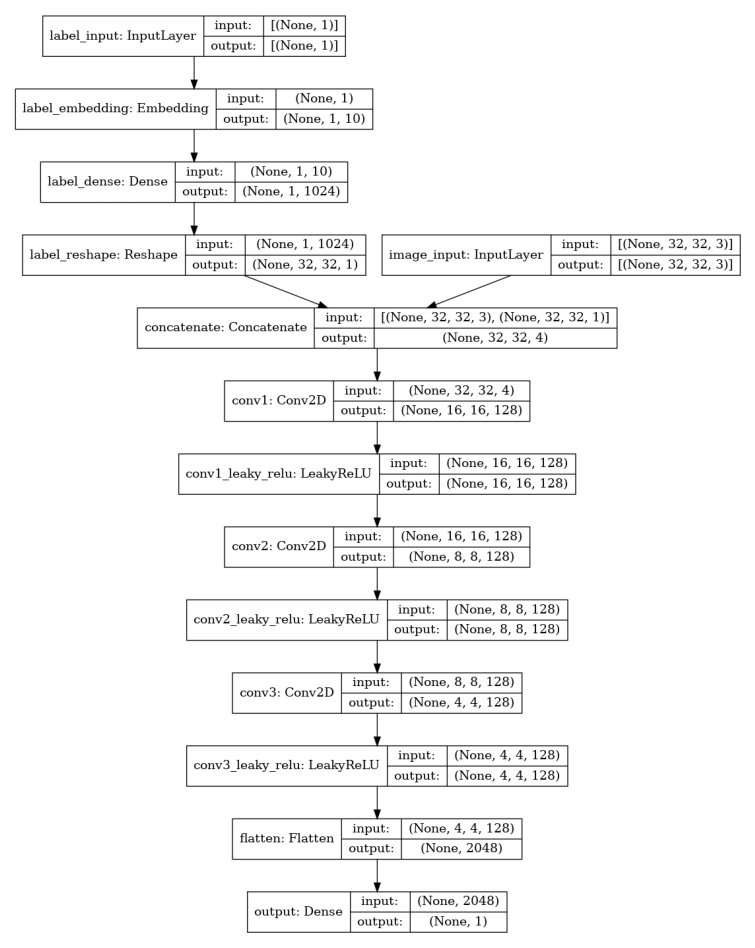

In [ ]:
# visualize discriminator
# plot_model(discriminator, show_shapes=True, to_file='images\model_architecture\Conditional_DCGAN\discriminator.png')
# discriminator_img = mpimg.imread('images\model_architecture\Conditional_DCGAN\discriminator.png')

# plt.figure(figsize=(10, 10))
# imgplot = plt.imshow(discriminator_img)
# plt.axis('off')
# plt.show()

In [14]:
# test untrained discriminator
decision = discriminator([generated_image, label], training=False)
print(decision)

tf.Tensor([[0.49979773]], shape=(1, 1), dtype=float32)


### Defining cDCGAN

In [15]:
class ConditionalGAN(Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.d_acc_metric = keras.metrics.BinaryAccuracy(name='d_acc')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric, self.d_acc_metric]

    def train_step(self, data):
        real_images, class_labels = data
        batch_size = tf.shape(real_images)[0]

        # train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_class_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=10, dtype='int32')
        generated_images = self.generator([random_latent_vectors, random_class_labels], training=False)

        # combine real and generated images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # combine real and generated labels
        combined_class_labels = tf.concat([random_class_labels, class_labels], axis=0)

        # fake labels are 1s because we want discriminator to think they are real
        fake_labels = tf.ones((batch_size, 1))  # (batch_size, 1)
        # real labels are 0s because we want discriminator to think they are fake
        real_labels = tf.zeros((batch_size, 1))  # (batch_size, 1)
        # combine labels
        combined_labels = tf.concat([fake_labels, real_labels], axis=0)  # (2*batch_size, 1)

        # train the discriminator
        with tf.GradientTape() as disc_tape:
            pred_on_combined = self.discriminator([combined_images, combined_class_labels], training=True)
            d_loss = self.loss_fn(combined_labels, pred_on_combined)  # log(D(x)) + log(1 - D(G(z))
        disc_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        # train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_class_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=10, dtype='int32')
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as gen_tape:
            pred_on_fake = self.discriminator([self.generator([random_latent_vectors, random_class_labels], training=True), random_class_labels], training=False)
            g_loss = self.loss_fn(misleading_labels, pred_on_fake)  # log(D(G(z))
        gen_grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))

        # update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        self.d_acc_metric.update_state(combined_labels, pred_on_combined)

        return {
            'g_loss': self.g_loss_metric.result(), 
            'd_loss': self.d_loss_metric.result(),
            'd_acc': self.d_acc_metric.result()
        }

In [16]:
class GANMonitor(Callback):
    def __init__(self, latent_dim, label_map):
        self.latent_dim = latent_dim
        self.label_map = label_map

    def on_epoch_end(self, epoch, logs=None):
        latent_vectors = tf.random.normal(shape=(100, self.latent_dim))
        class_labels = tf.reshape(tf.range(10), shape=(10, 1))
        class_labels = tf.tile(class_labels, multiples=(1, 10))
        class_labels = tf.reshape(class_labels, shape=(100, 1))

        generated_images = self.model.generator([latent_vectors, class_labels], training=False)
        generated_images = (generated_images + 1) / 2

        if not os.path.exists('images/cdcgan_images'):
            os.makedirs('images/cdcgan_images')

        if epoch % 10 == 0:
            fig, axes = plt.subplots(10, 10, figsize=(20, 20))
            axes = axes.flatten()

            for i, ax in enumerate(axes):
                ax.imshow(generated_images[i])
                ax.set_title(self.label_map[class_labels[i].numpy().item()], fontsize=16)
                ax.axis('off')

            plt.tight_layout()
            plt.savefig(f'images/cdcgan_images/generated_img_{epoch}.png')
            plt.close()

## Training cDCGAN

In [17]:
LATENT_DIM = 128    
EPOCHS = 1000

label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
callbacks = [GANMonitor(LATENT_DIM, label_map)]

cdcgan = ConditionalGAN(
    generator=create_generator(LATENT_DIM), 
    discriminator=create_discriminator(), 
    latent_dim=LATENT_DIM
)

cdcgan.compile(
    g_optimizer=Adam(learning_rate=2e-3, beta_1=0.5),
    d_optimizer=Adam(learning_rate=2e-3, beta_1=0.5),
    loss_fn=MeanSquared
)

In [18]:
%%time
history = cdcgan.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/1000
469/469 [==============================] - 32s 60ms/step - g_loss: 2.0888 - d_loss: 0.4127 - d_acc: 0.8635
Epoch 2/1000
469/469 [==============================] - 20s 43ms/step - g_loss: 1.5997 - d_loss: 0.5012 - d_acc: 0.7963
Epoch 3/1000
469/469 [==============================] - 20s 43ms/step - g_loss: 0.9949 - d_loss: 0.6237 - d_acc: 0.6739
Epoch 4/1000
469/469 [==============================] - 20s 43ms/step - g_loss: 0.9392 - d_loss: 0.6328 - d_acc: 0.6619
Epoch 5/1000
469/469 [==============================] - 20s 43ms/step - g_loss: 0.8930 - d_loss: 0.6403 - d_acc: 0.6535
Epoch 6/1000
469/469 [==============================] - 20s 43ms/step - g_loss: 0.9620 - d_loss: 0.6278 - d_acc: 0.6699
Epoch 7/1000
469/469 [==============================] - 20s 42ms/step - g_loss: 1.0645 - d_loss: 0.6042 - d_acc: 0.7017
Epoch 8/1000
469/469 [==============================] - 20s 44ms/step - g_loss: 0.9843 - d_loss: 0.6151 - d_acc: 0.6813
Epoch 9/1000
469/469 [==================

## Model Evaluation

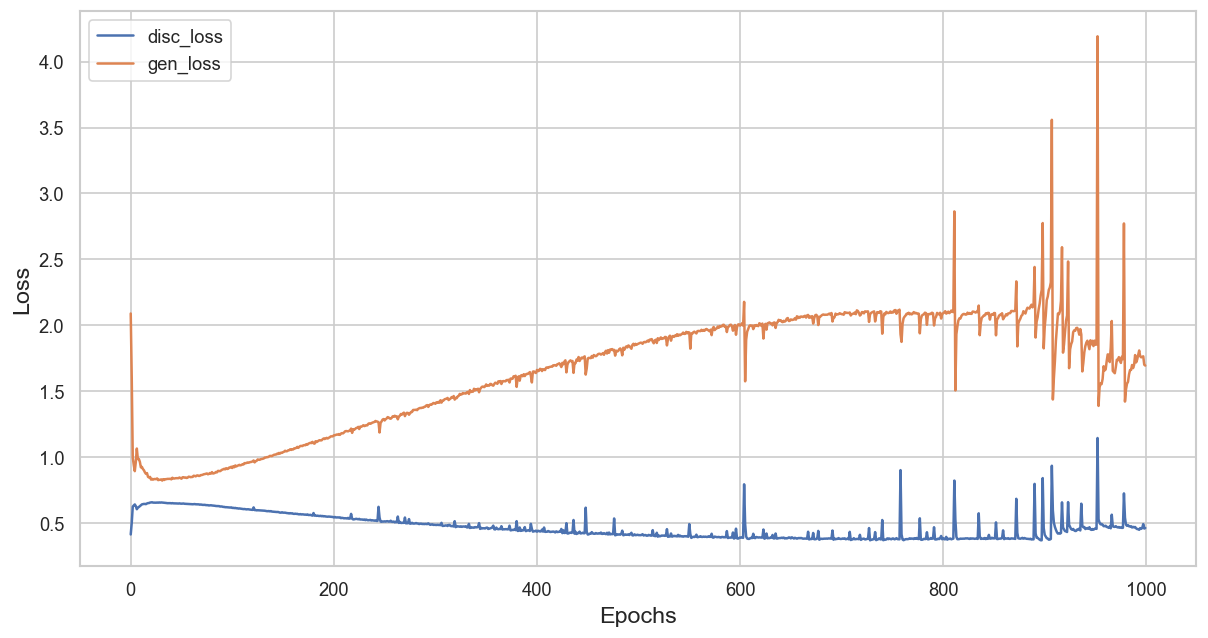

In [19]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_loss'], label='disc_loss')
plt.plot(history.history['g_loss'], label='gen_loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()
plt.show()

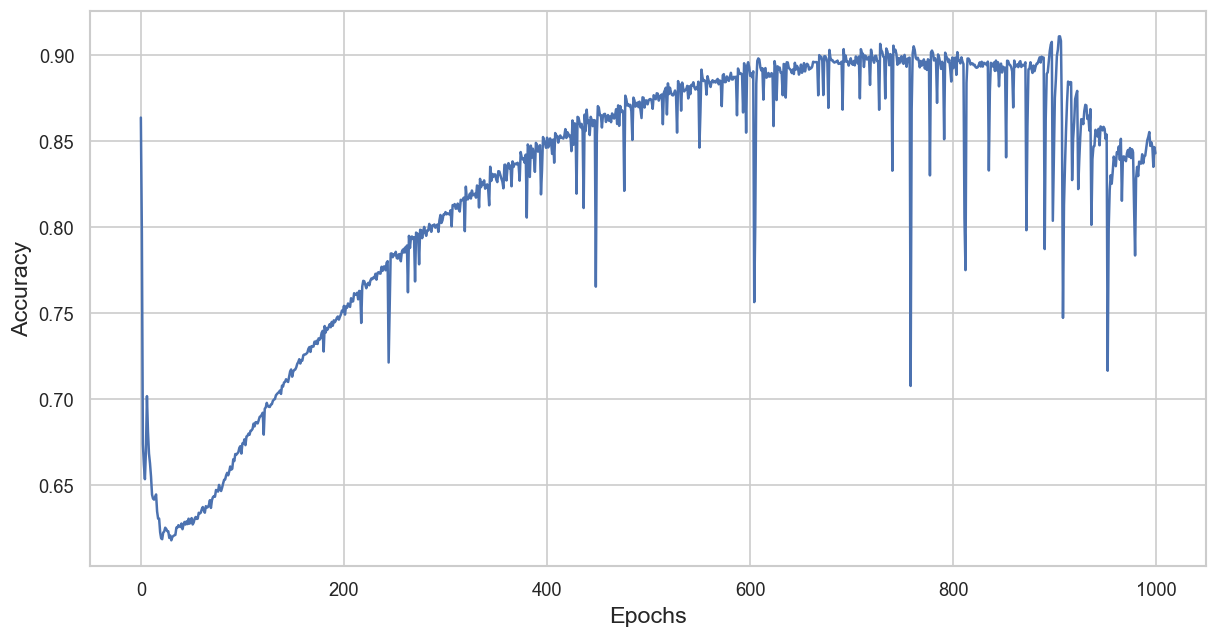

In [20]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_acc'], label='disc_acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.show()

In [21]:
latent_vectors = tf.random.normal(shape=(100, LATENT_DIM))
class_labels = tf.reshape(tf.range(10), shape=(10, 1))
class_labels = tf.tile(class_labels, multiples=(1, 10))
class_labels = tf.reshape(class_labels, shape=(100, 1))

generated_images = cdcgan.generator([latent_vectors, class_labels], training=False)
generated_images = (generated_images + 1) / 2

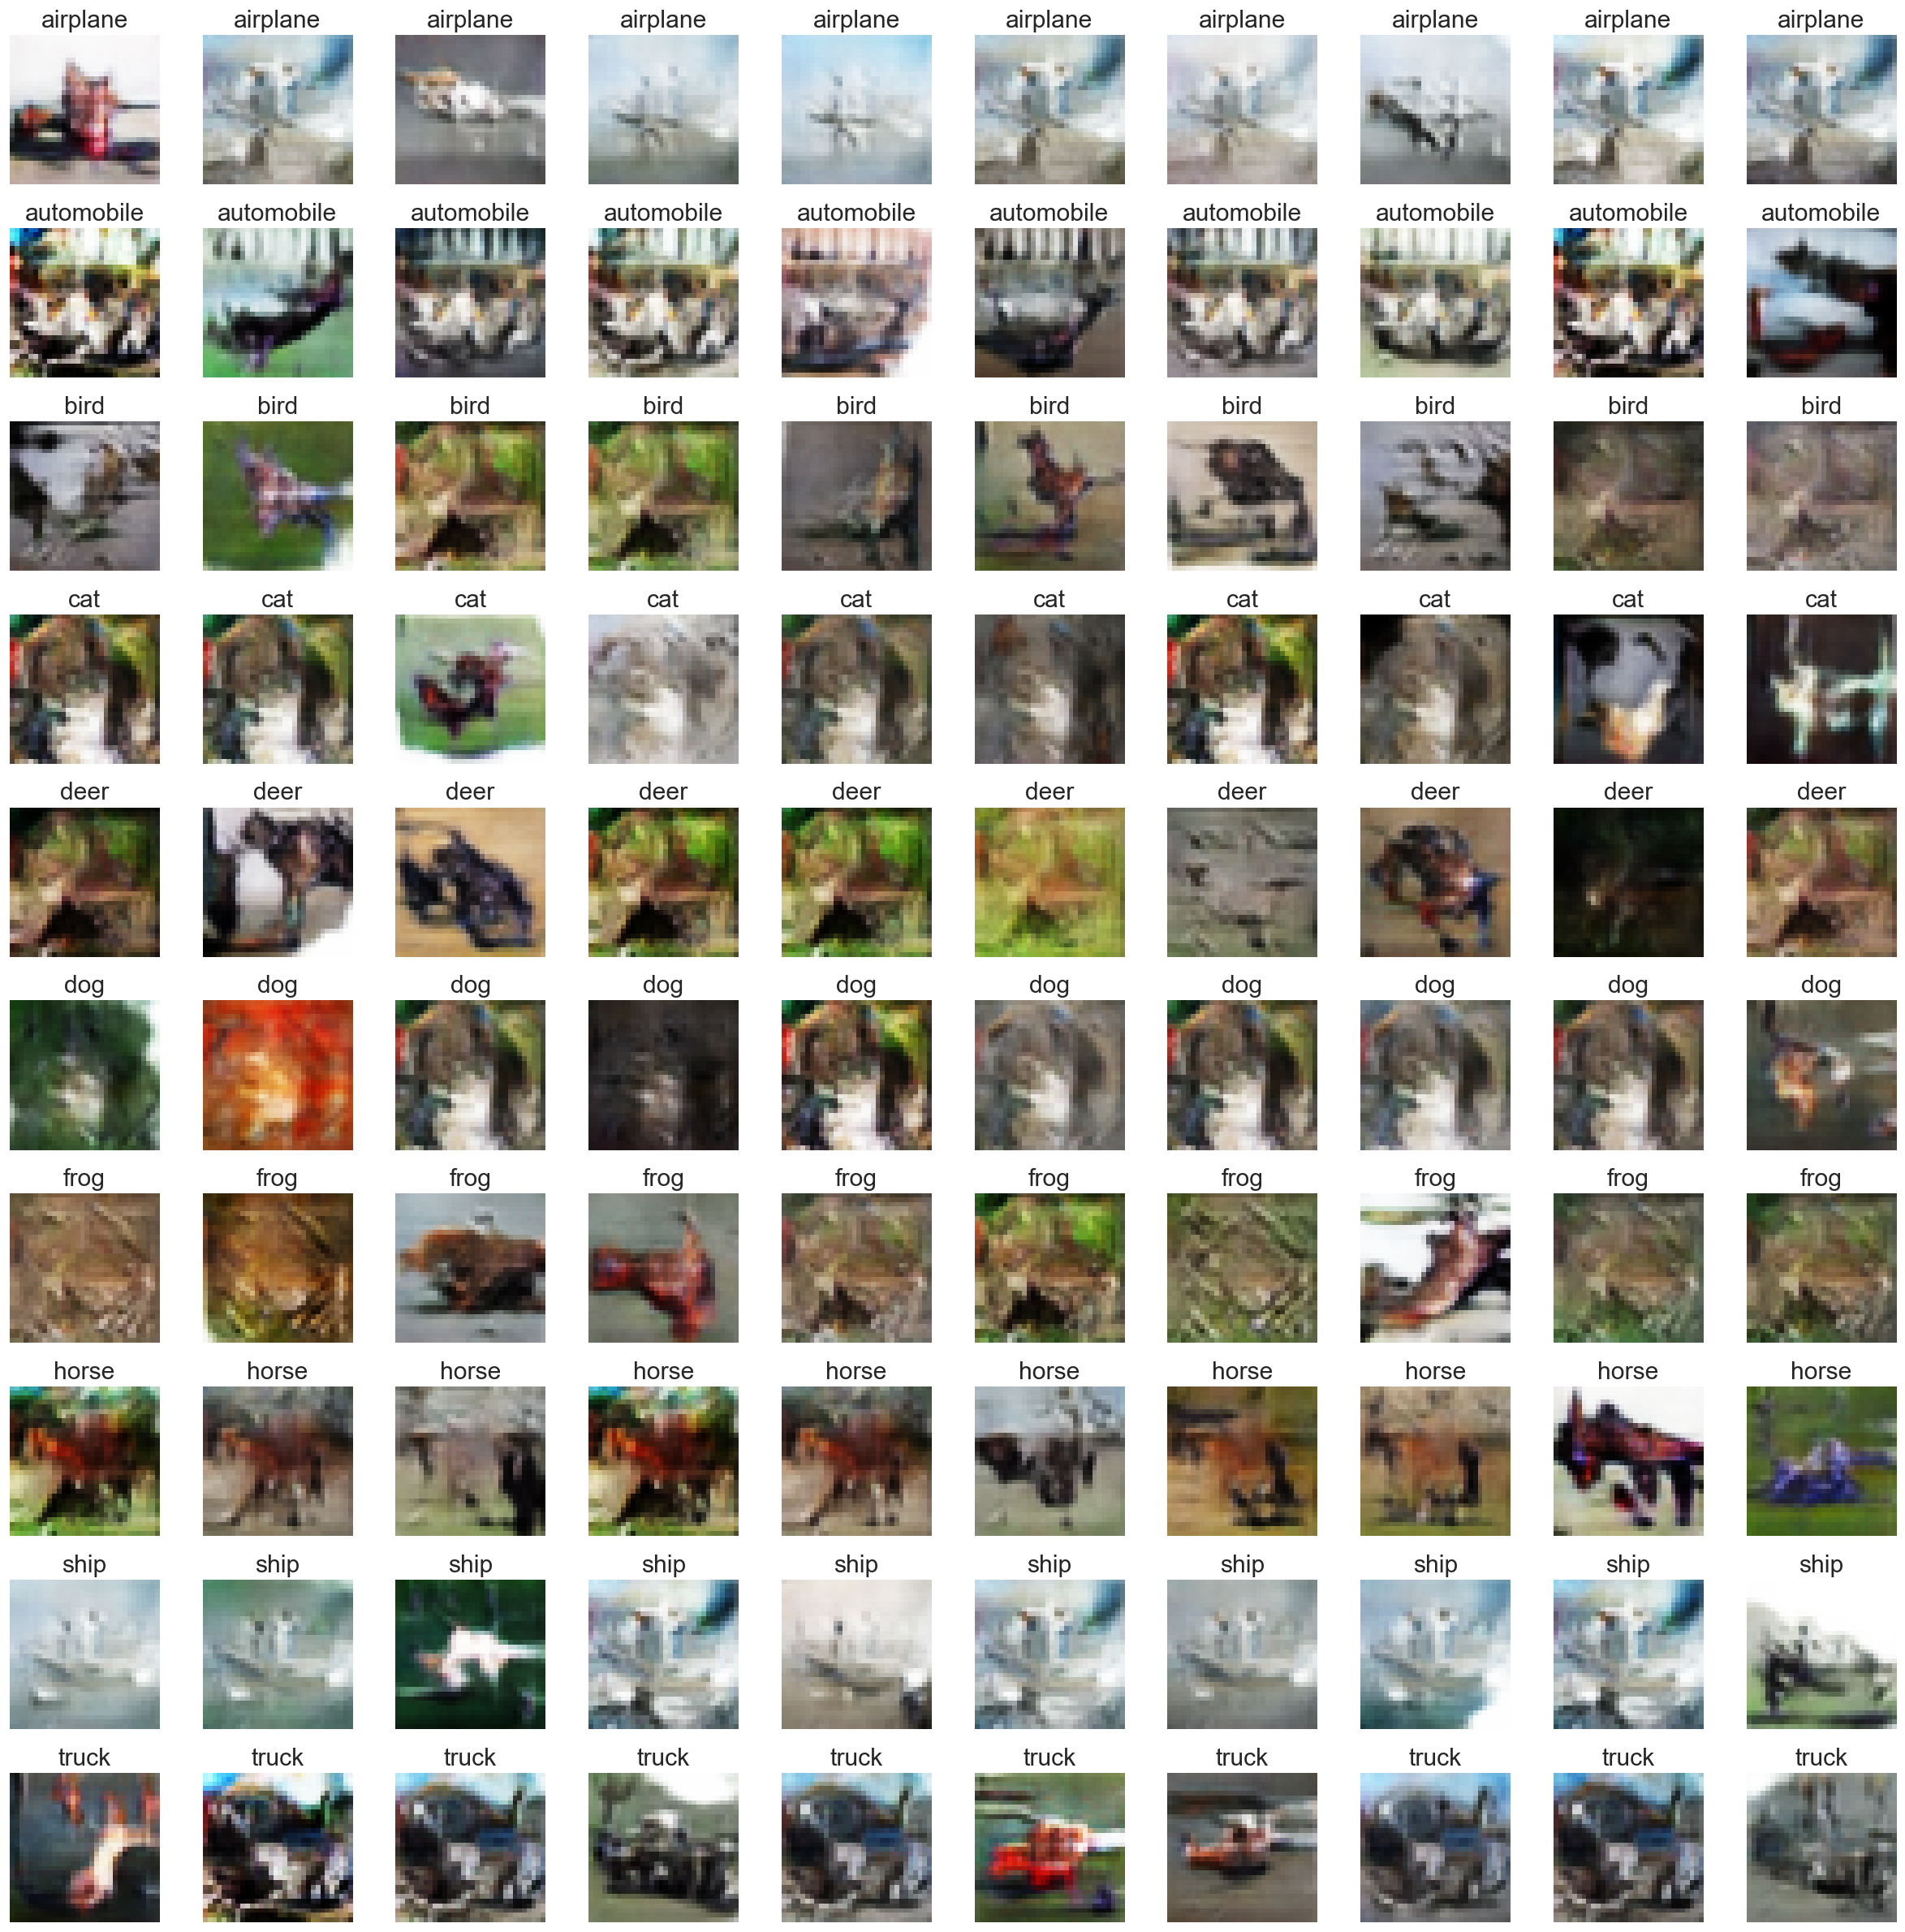

In [22]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.set_title(label_map[class_labels[i].numpy().item()], fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Export Model and Performance Metrics

In [33]:
if not os.path.exists('./assets'):
    os.mkdir('./assets/')

cdcgan.save_weights('./assets/cdcgan_weights.h5')

In [34]:
# export dcgan loss and acc results
if not os.path.exists('performance'):
    os.makedirs('performance')

cdcgan_perf = dict(
    g_loss=history.history['g_loss'],
    d_loss=history.history['d_loss'],
    d_acc=history.history['d_acc'],
)

with open('performance/cdcgan_perf.pickle', 'wb') as f:
    pickle.dump(cdcgan_perf, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('performance/cdcgan_perf.pickle', 'rb') as f:
    unserialized_data = pickle.load(f)

assert cdcgan_perf == unserialized_data